In [1]:
import os, tqdm

import torch
import argparse
import pprint, ast
import numpy as np
import torchvision
from torchvision import transforms
from einops import reduce
from functools import partial
from image_et import ImageET as ET, Patch, GetCIFAR, count_parameters, device, gen_mask_id
from torch.utils.data.dataloader import DataLoader

In [2]:
trainset, testset, unnormalize_fn = GetCIFAR('../data/', 'CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#FOLDER = './image_et/example_model'
FOLDER = './example_model'

f = open(FOLDER + "/model_config.txt", "r")
config = ast.literal_eval(f.read())
pprint.pprint(config)
f.close()

{'alpha': 5.0,
 'attn_beta': 16.0,
 'attn_bias': False,
 'avg_gpu': True,
 'b1': 0.99,
 'b2': 0.999,
 'batch_size': 512,
 'blocks': 1,
 'data_name': 'CIFAR10',
 'data_path': '../data',
 'epochs': 10000,
 'hn_bias': False,
 'hn_mult': 4.0,
 'kernel_size': 4,
 'learning_rate': 5e-05,
 'mask_ratio': 0.85,
 'nheads': 12,
 'num_workers': 4,
 'out_dim': None,
 'qk_dim': 64,
 'result_path': './results',
 'time_steps': 12,
 'tkn_dim': 768,
 'weight_decay': 0.001}


In [4]:
x = torch.randn(1, 3, 32, 32)

model = ET(
    x,
    Patch(config['kernel_size']),
    config["out_dim"],
    config["tkn_dim"],
    config["qk_dim"],
    config["nheads"],
    config["hn_mult"],
    config["attn_beta"],
    config["attn_bias"],
    config["hn_bias"],
    time_steps=config["time_steps"],
    blocks=config["blocks"],
)

print('PARAM COUNT:', count_parameters(model), '\n')

model.load_state_dict(torch.load(FOLDER + '/model.pth'))
model.eval()

PARAM COUNT: 3667249 



ET(
  (patch): Patch(
    (transform): Lambda()
    (revert): Lambda()
  )
  (encode): Sequential(
    (0): Linear(in_features=48, out_features=768, bias=True)
  )
  (decode): Sequential(
    (0): LayerNorm((768,), eps=768, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=48, bias=True)
  )
  (pos): PositionEncode()
  (blocks): ModuleList(
    (0): ModuleList(
      (0): EnergyLayerNorm()
      (1): ETBlock(
        (hn): Hopfield(
          (fn): Lambda()
          (proj): Linear(in_features=768, out_features=3072, bias=False)
        )
        (attn): Attention()
      )
    )
  )
)

In [5]:
patch_fn = model.patch

ALPHA = config['alpha']
DEVICE = device()
MASK_RATIO = 0.5
NUM_PATCH = patch_fn(x).size(1)

In [6]:
model = model.to(DEVICE)
print(DEVICE)

cuda


# VISUALIZE TOKEN EVOLUTION

In [15]:
import imageio, matplotlib.pyplot as plt

test_loader = DataLoader(testset, shuffle=True, batch_size = 32)

for x, _ in test_loader:
    x = x.to(DEVICE)
    mask_id = gen_mask_id(NUM_PATCH, int(MASK_RATIO * NUM_PATCH), 1).to(DEVICE)
    energy, embeddings = model.visualize(x, mask_id, ALPHA)
    break

energy = [e.detach().cpu() for e in energy]
embeddings = [unnormalize_fn(e.detach().cpu()) for e in embeddings]

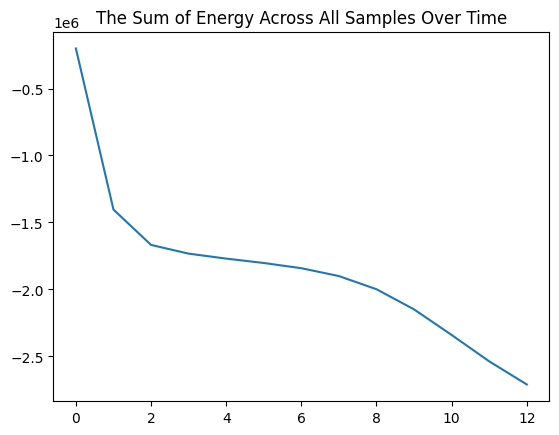

In [16]:
plt.title('The Sum of Energy Across All Samples Over Time')
plt.plot(energy)
plt.show()

In [18]:
for img_id in range(min(x.size(0), 16)):
    with imageio.get_writer('./animations/ex_{0}.gif'.format(img_id), format="GIF", mode='I', duration= 1 / 5000) as writer:
        for i in range(len(embeddings)):
            image = transforms.Resize((128, 128), antialias=False, interpolation=transforms.InterpolationMode.NEAREST)(embeddings[i][img_id]).permute(1, 2, 0) + 1e-8
            image.clamp_(0, 255)
            image = image.to("cpu", torch.uint8).numpy()
            writer.append_data(image)